### Project: Understanding Employee Attrition with Machine Learning 
### Activity: Feature Selection, Logistic Regression Modelling & Model Evaluation 
### Model: Logistic Regression
### Author: Tawanda Nigel Chitapi
### Email: nigel.chitapi@gmail.com    
### Date: September 05, 2022
### Institution: BrainStation

In [1]:
# import packages

# the data science trinity
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# seaborn
import seaborn as sns

# model selection tools
from sklearn.model_selection import train_test_split

# scaler
from sklearn.preprocessing import StandardScaler

# linear models
from sklearn.linear_model import LogisticRegression

# metrics
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_curve, roc_auc_score

# SMOTE
from imblearn.over_sampling import SMOTE

### The goal of this notebook is achieve the following:

- Perform Feature Selection to pick only those features that are best predictors of the target variable

- Check if target feature classes are balanced, if they are not balanced, we ought to perform some data upsampling

- Fit data into a Logistic Regression Model and determine accuracies

- Evaluate overall model performance 


In [2]:
# load our data 

employee_df = pd.read_csv('data/employee_attrition.csv')

In [3]:
# sanity check to see if our data loaded successfully

employee_df.head()

,EmployeeID,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EnvironmentSatisfaction,Gender,HourlyRate,...,Other,Technical Degree,Admin,Administrative,Nurse,Other.1,Therapist,Divorced,Married,Single
0,1313919,41,0,1102,1,2,1,2,1,94,...,0,0,0,0,1,0,0,0,0,1
1,1200302,49,0,279,8,1,1,3,0,61,...,0,0,0,0,0,1,0,0,1,0
2,1060315,37,1,1373,2,2,1,4,0,92,...,1,0,0,0,1,0,0,0,0,1
3,1272912,33,0,1392,3,4,1,4,1,56,...,0,0,0,0,0,1,0,0,1,0
4,1414939,27,0,591,2,1,1,1,0,40,...,0,0,0,0,1,0,0,0,1,0


In [4]:
# sanity check, to ensure all data types are numerical 
employee_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1676 entries, 0 to 1675
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   EmployeeID                1676 non-null   int64
 1   Age                       1676 non-null   int64
 2   Attrition                 1676 non-null   int64
 3   DailyRate                 1676 non-null   int64
 4   DistanceFromHome          1676 non-null   int64
 5   Education                 1676 non-null   int64
 6   EmployeeCount             1676 non-null   int64
 7   EnvironmentSatisfaction   1676 non-null   int64
 8   Gender                    1676 non-null   int64
 9   HourlyRate                1676 non-null   int64
 10  JobInvolvement            1676 non-null   int64
 11  JobLevel                  1676 non-null   int64
 12  JobSatisfaction           1676 non-null   int64
 13  MonthlyIncome             1676 non-null   int64
 14  MonthlyRate               1676 non-null 

### Now we will dive into our Logistic Regression modelling journey

## Logistic Regression

Logistic regression is one of the most basic (yet effective) tools we have for classifying categorical data.


With *linear* regression, we model data using linear equations of the form: 

$$f(X) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_d x_d$$

This equation outputs numerical predictions from numerical input attributes. Each $\beta_i$ represents how much our model weighs $x_i$ in predicting the output values. 

We will modify this function to get *categorical* predictions 

With logistic regression, we take advantage of the **sigmoid curve**:
$$ s(X) = \frac{1}{1+e^{-x}} $$

where $e$ is the value $e = 2.71828182845...$ and is often called [**Euler's Number**]

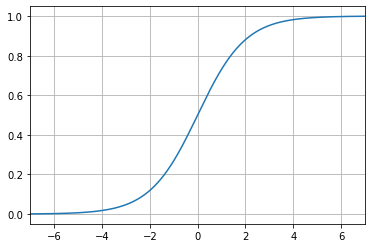

In [5]:
# defining the sigmoid curve manually
def sigmoid_curve(x):
    return 1 / (1 + np.exp(-x)) # exp(x) is the function to calculate e^x

# for many x values, we will calculate s(x)
x_points = np.arange(-7, 7, 0.01)

plt.figure()
plt.plot(x_points, sigmoid_curve(x_points))
plt.grid()
plt.xlim(-7,7)
plt.show()

We take the linear function...
$$ f(X) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_d x_d $$

... and feed it into the sigmoid curve...
$$ s(X) = \frac{1}{1+e^{-f(X)}} $$

... to create our final predictive model:
$$ s(X) = \frac{1}{1+e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_d x_d)}} $$


Now our model has two nice properties:

   1. It is bounded between 0 and 1 (just like a probability)
   2. It is smooth, it never makes a sharp jump
    
* The first property means that we can interpret $s(X)$ as the probability that $X$ belongs to a particular class (say class $1$). By extension, this also gives us the probability that $X$ belongs to the other class, $1-s(X)$. 

* The second property is not as directly useful to us, but it makes it easy for Python to solve several underlying equations when fitting the model, (e.g. the gradient of the function).

Once we have our model's estimate we can make a decision on which class it belongs to. 

Since $X$ must belong to one of the two classes, we assign it to the class our model believes is more likely. This is to say that we assign it to class $1$ if $s(X) \geq 1-s(X)$, otherwise we assign it to class $0$. 

For example, in our case, we want to predict if an employee will attrition or not. Attrition is class 1 and staying on the job is class 0. Our model tells us: 

|    Class  |  0  |  1  | 
| --------- |:---:|:---:|
|Probability|0.73 |0.27 | 

These are called **soft predictions.** This means that there a 0.73 probability that the employee will **stay on the job** and a 0.27 probability that the employee **will attrtion**. These two should addup to **1.**  

We now have to make the **hard prediction** of saying if that the employee will **stay on the job. Since Class 0 is more likely than Class 1, we can make a decision to predict that the individual will stay on the job.** 

Equivalently, in a two-class scenario, we can look at the probability of Class 1 happening and predict Class 1 if the probability is larger than 0.5.

# First we will distinguish the Independent Features "X" and the Dependent Feature "Y"

In [6]:
# independent features
X = employee_df.drop(['Attrition'], axis=1)

# dependent feature (Attrition)
y = employee_df['Attrition']

In [7]:
# check the independent features

X

,EmployeeID,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,...,Other,Technical Degree,Admin,Administrative,Nurse,Other.1,Therapist,Divorced,Married,Single
0,1313919,41,1102,1,2,1,2,1,94,3,...,0,0,0,0,1,0,0,0,0,1
1,1200302,49,279,8,1,1,3,0,61,2,...,0,0,0,0,0,1,0,0,1,0
2,1060315,37,1373,2,2,1,4,0,92,2,...,1,0,0,0,1,0,0,0,0,1
3,1272912,33,1392,3,4,1,4,1,56,3,...,0,0,0,0,0,1,0,0,1,0
4,1414939,27,591,2,1,1,1,0,40,3,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1671,1117656,26,471,24,3,1,3,0,66,1,...,0,1,0,0,1,0,0,0,0,1
1672,1152327,46,1125,10,3,1,3,1,94,2,...,0,0,0,0,1,0,0,0,1,0
1673,1812428,20,959,1,3,1,4,1,83,2,...,0,0,0,0,0,1,0,0,0,1
1674,1812429,39,466,1,1,1,4,1,65,2,...,0,0,0,0,0,0,1,0,1,0


In [8]:
# check the dependent feature 'attrition'

y

0       0
1       0
2       1
3       0
4       0
       ..
1671    1
1672    0
1673    0
1674    0
1675    0
Name: Attrition, Length: 1676, dtype: int64

### Now we will move on to perform Feature Selection 

- Our Independent data contains 49 columns, 49 columns are too wide a dimension and puts our model at the risk of the curse of dimensionality especially given that we only have 1676 rows.

- In order to best predict our target variable class, we need to conduct some feature selection and select only those variables that best predict the target variable class.

- To achieve this we will use the Fisher - Chi-Squared test and assess the derived p-values to select on the best predictors which are features with p-values less than the significance threshold of 0.05


In [9]:
# import the chi2 feature selection package

from sklearn.feature_selection import chi2

In [10]:
# create the chi2 variable and apply on the X and y variables
f_p_values = chi2(X, y)

f_p_values

(array([1.21143359e+03, 2.18075488e+02, 9.80042735e+02, 1.34752206e+02,
        9.14675779e-01, 0.00000000e+00, 7.62324266e+00, 4.26023102e-01,
        1.37660534e+01, 8.64185842e+00, 4.33138845e+01, 4.99790687e+00,
        2.15238646e+05, 1.25027767e+04, 1.15322155e+00, 0.00000000e+00,
        1.36592523e+02, 1.26983331e-02, 7.82147747e-03, 2.99901161e-01,
        0.00000000e+00, 3.81226029e+01, 4.97310855e+02, 2.98027378e+00,
        2.44735458e+00, 3.59223808e+02, 2.23346033e+02, 5.90028751e+01,
        2.07527896e+02, 1.08669784e+00, 1.07867314e+01, 1.71639456e+00,
        2.15864231e+00, 1.45973417e-01, 5.70868185e+00, 2.15412094e+00,
        2.11386774e-02, 1.56263236e+00, 2.29483170e+00, 6.51176112e-01,
        1.19062460e+00, 2.15572106e+00, 1.33078829e+01, 1.02725034e+00,
        9.96392145e+00, 1.71956394e+01, 1.09284509e+01, 1.20169006e+01,
        4.95438134e+01]),
 array([1.99742170e-265, 2.37780925e-049, 3.91110641e-215, 3.74056454e-031,
        3.38876833e-001, 1.0000000

The variable **f_p_values** refers to f-score & p-value values, the first array [0] represents f-scores and the second array [1] represent the p-values.

In [11]:
# our significance threshold is 0.05 and so we will only select those features with p-values less than 0.05
p_values = f_p_values[1]< 0.05

In [12]:
# create a series of p_values and match them to the relevant columns 

selected_features = pd.Series(p_values, index = X.columns)

In [13]:
# sort the p_values in descending order 
selected_features.sort_values(ascending = False , inplace = True)

In [14]:
# display features
selected_features 

EmployeeID                   True
OverTime                     True
Married                      True
Divorced                     True
Therapist                    True
Other.1                      True
Administrative               True
Neurology                    True
Travel_Frequently            True
YearsWithCurrManager         True
YearsSinceLastPromotion      True
YearsInCurrentRole           True
YearsAtCompany               True
Age                          True
TotalWorkingYears            True
Shift                        True
Single                       True
JobSatisfaction              True
HourlyRate                   True
DailyRate                    True
DistanceFromHome             True
MonthlyRate                  True
MonthlyIncome                True
JobLevel                     True
JobInvolvement               True
EnvironmentSatisfaction      True
Medical                     False
Other                       False
Technical Degree            False
Admin         

- We will go on and create a new subset of X features, using only the features with **"True"** values, meaning they have p-values less than 0.05. These are our best predictors.



In [15]:
# we will create a new variable for X, with our newly identified features, those with p-values < 0.05

X = X[['EmployeeID', 'OverTime', 'Married', 'Divorced','Therapist',
                'Other.1', 'Administrative', 'Travel_Frequently','YearsWithCurrManager',
                'YearsSinceLastPromotion', 'YearsInCurrentRole', 'YearsAtCompany','Age',
                'TotalWorkingYears', 'Shift', 'Single', 'JobSatisfaction', 'DailyRate', 
                'MonthlyIncome','JobLevel', 'EnvironmentSatisfaction', 'HourlyRate']]

## Before we finalize our feature selection we need to ensure we avoid any multi-collinearity of the independent features and so we will  assess correlation of our newly selected "X" features 

In [16]:
# calculate correlation of X_train features
X.corr()

,EmployeeID,OverTime,Married,Divorced,Therapist,Other.1,Administrative,Travel_Frequently,YearsWithCurrManager,YearsSinceLastPromotion,...,Age,TotalWorkingYears,Shift,Single,JobSatisfaction,DailyRate,MonthlyIncome,JobLevel,EnvironmentSatisfaction,HourlyRate
EmployeeID,1.000000,-0.027952,-0.017187,0.000210,0.011081,0.022057,0.018420,-0.001679,-0.013707,0.031340,...,-0.039033,-0.031294,-0.003884,0.018318,-0.007392,-0.002558,-0.027595,-0.030085,-0.005930,0.000007
OverTime,-0.027952,1.000000,-0.012405,0.028293,-0.015384,0.049238,-0.019162,0.030692,-0.049998,-0.027633,...,0.030970,0.019880,0.009751,-0.012152,0.017259,0.013474,0.011969,0.006171,0.076885,-0.015575
Married,-0.017187,-0.012405,1.000000,-0.500837,0.020346,-0.034832,0.036375,-0.016296,0.039595,0.047891,...,0.087163,0.056776,0.212182,-0.625263,-0.006441,0.033362,0.058937,0.055978,-0.026605,0.041855
Divorced,0.000210,0.028293,-0.500837,1.000000,0.015750,-0.003429,0.012051,0.000069,0.000778,-0.016633,...,0.025896,0.027044,0.449617,-0.362325,-0.016153,0.049534,0.028530,0.030563,0.022820,-0.015792
Therapist,0.011081,-0.015384,0.020346,0.015750,1.000000,-0.243788,-0.096766,-0.005212,0.087145,0.003570,...,0.066814,0.087889,0.003639,-0.036111,-0.004456,-0.016433,0.090090,0.148062,0.053129,-0.017635
Other.1,0.022057,0.049238,-0.034832,-0.003429,-0.243788,1.000000,-0.185603,0.026205,-0.146215,-0.059912,...,-0.115285,-0.172149,-0.033613,0.040601,-0.017922,0.008571,-0.205051,-0.268842,-0.017158,-0.007548
Administrative,0.018420,-0.019162,0.036375,0.012051,-0.096766,-0.185603,1.000000,-0.065798,0.168081,0.116193,...,0.254053,0.424881,-0.007451,-0.050036,0.002253,-0.029636,0.581717,0.509565,-0.004736,0.016232
Travel_Frequently,-0.001679,0.030692,-0.016296,0.000069,-0.005212,0.026205,-0.065798,1.000000,0.004547,0.022498,...,-0.030146,-0.019856,-0.010557,0.017486,0.040752,-0.012983,-0.042703,-0.033256,-0.007935,-0.016717
YearsWithCurrManager,-0.013707,-0.049998,0.039595,0.000778,0.087145,-0.146215,0.168081,0.004547,1.000000,0.518664,...,0.215909,0.461688,0.014314,-0.043339,-0.023042,-0.025272,0.350122,0.379717,-0.012417,-0.021436
YearsSinceLastPromotion,0.031340,-0.027633,0.047891,-0.016633,0.003570,-0.059912,0.116193,0.022498,0.518664,1.000000,...,0.217212,0.394941,0.011702,-0.036574,-0.013595,-0.034571,0.337241,0.343102,0.005866,-0.028642


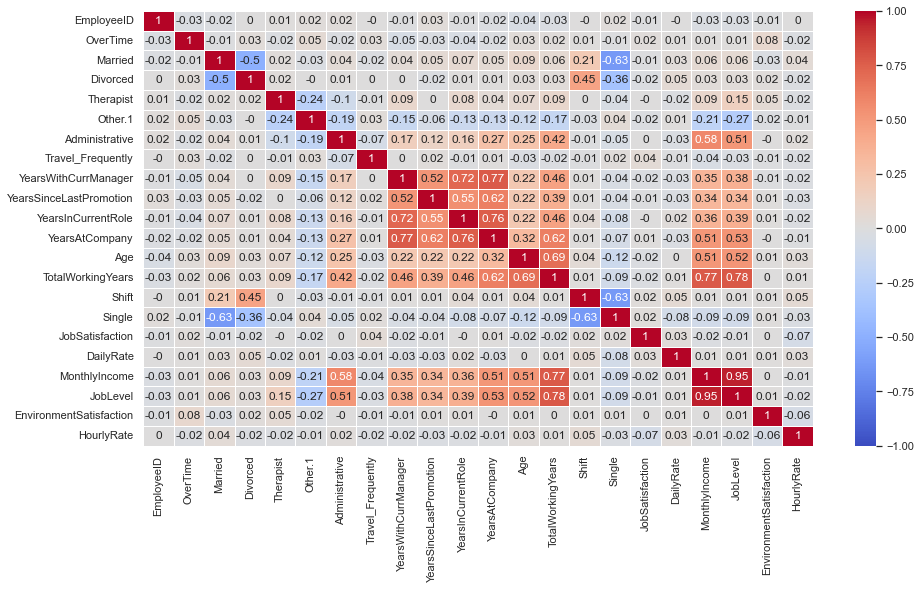

In [17]:
# plot correlation heatmap for better visualization

sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(X.corr().round(2), vmin=-1, vmax=1, cmap='coolwarm', annot=True, linewidths=0.5)
plt.show()

### We will use a threshold of ** -0.6 and +0.6** as a threshold to determine strong correlation, and any value below -0.6 will be determined as a strong correlation and any value above +0.6 as a strong correlation.

#### From the observation made from the heatmap, we will drop the following features to avoid multi-collinearity:

- YearsInCurrentRole
- YearsAtCompany
- YearsSinceLastPromotion
- YearsWithCurrManager
- MonthlyIncome
- TotalWorkingYears
- EmployeeID **(this feature does not tell us much about the employee characteristics, other than identifying them)**


In [18]:
# drop the identified collinear features and define the newly update X variable
X = X.drop(['YearsInCurrentRole', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
           'MonthlyIncome', 'TotalWorkingYears', 'EmployeeID'], axis=1)

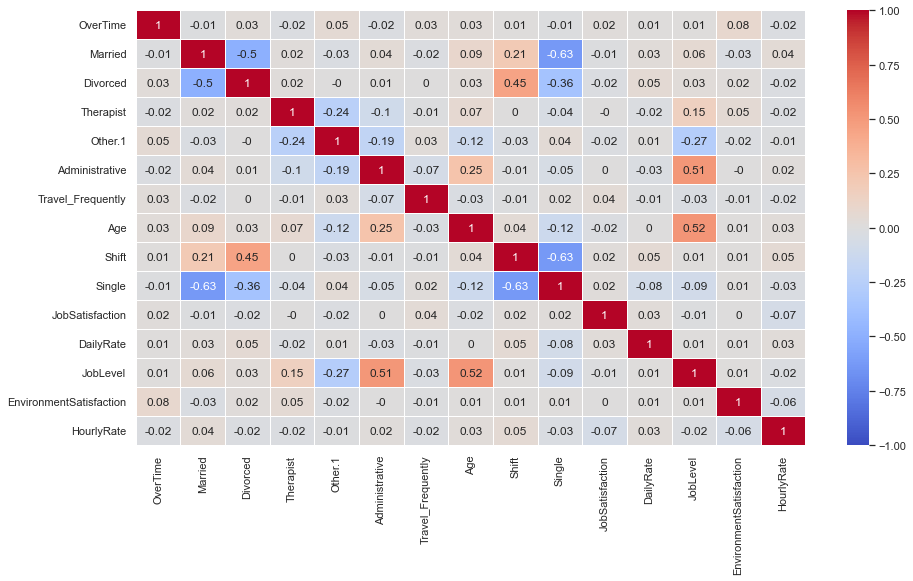

In [19]:
# plot correlation heatmap to verify if the remaining features are not correlated

sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(X.corr().round(2), vmin=-1, vmax=1, cmap='coolwarm', annot=True, linewidths=0.5)
plt.show()

After our second iteration of checking for correlation, it turned out that the **Shift and Single** features are correlated and so we will go ahead and drop them from the selected features

In [20]:
# drop the identified correlated features
X = X.drop(['Shift', 'Single'], axis=1)

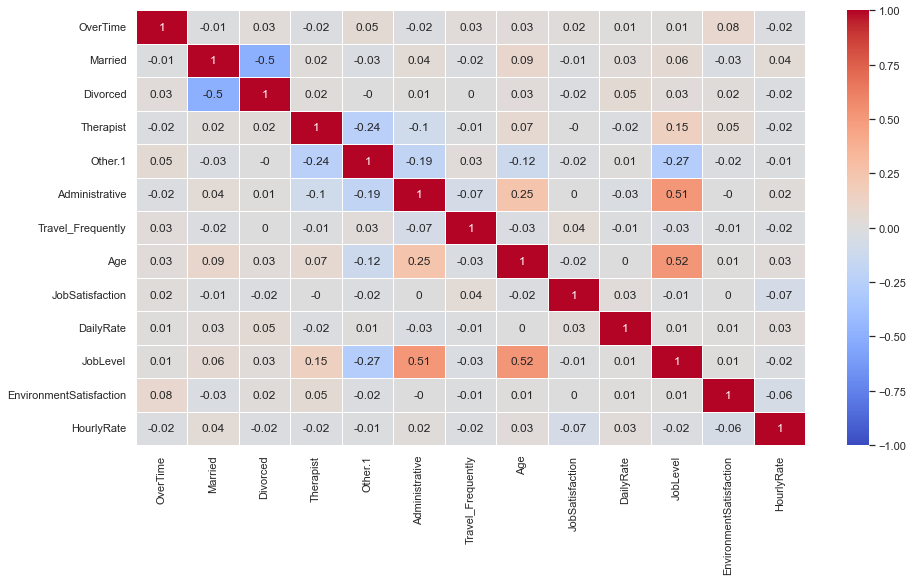

In [21]:
# plot correlation heatmap to verify if the remaining features are not strongly correlated

sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(X.corr().round(2), vmin=-1, vmax=1, cmap='coolwarm', annot=True, linewidths=0.5)
plt.show()

From the correlation heatmap above we can observe that the remaining features are do not have a correlation value **above +0.6 or below -0.6** With that we can go ahead and make the remaining features our official **X features**

## Now that the best predictive features have been selected, we will go ahead and split our data into train and test sets

In [22]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.3,
    stratify = y,
    random_state = 1
)

In [23]:
X_train

,OverTime,Married,Divorced,Therapist,Other.1,Administrative,Travel_Frequently,Age,JobSatisfaction,DailyRate,JobLevel,EnvironmentSatisfaction,HourlyRate
16,1,0,1,0,1,0,0,32,2,334,1,1,80
1055,1,0,0,0,0,0,0,34,2,790,2,1,40
246,0,1,0,0,1,0,0,33,4,832,1,3,63
768,0,1,0,0,0,0,0,54,3,1082,3,3,41
1214,0,1,0,0,1,0,0,24,3,581,1,3,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,0,1,0,0,0,0,0,25,3,959,2,1,41
570,0,1,0,0,0,0,0,29,3,657,2,2,66
328,0,0,0,0,0,0,1,33,4,508,2,2,46
56,0,1,0,0,0,0,1,35,1,853,3,2,71


We have initiated an 70% train set and 30% test set split on our data 

- the split percentages are at our own discretion, the goal is to have sufficient enough data to train our model

#### Class imbalance is a common problem, that cause bias of our model accuracy and so It is important to check whether our dependent feature classes are balanced or not.

In [24]:
# check the distribution of target variable (attrition) classes

print('Attrition class distribution')
display(pd.Series(y_train).value_counts().sort_index())

Attrition class distribution


0    1034
1     139
Name: Attrition, dtype: int64

In [25]:
print (f'There is a significant class imbalance of {(139/1034)*100}% class 1, compared to {(1034/(1034+139))*100}% class 0.')

There is a significant class imbalance of 13.44294003868472% class 1, compared to 88.15004262574595% class 0.


We will need to upsample the data in the y_train dataset in order to balance the classes. 

**We will simply duplicate the data in the monirity class (class 1), this will not add any new information to the model, to achieve this we will augment the data using "SMOTE"** (Synthetic Minority Oversampling Technique)

In [26]:
# instantiate SMOTE sampler, fit it to the training data, then resample the data
X_train_sm, y_train_sm = SMOTE(random_state=1).fit_resample(X_train, y_train)

In [27]:
# sanity check to see what SMOTE has done

print('Original class distribution')
display(pd.Series(y_train).value_counts().sort_index())

print('\nResampled class distribution')
display(pd.Series(y_train_sm).value_counts().sort_index())

Original class distribution


0    1034
1     139
Name: Attrition, dtype: int64


Resampled class distribution


0    1034
1    1034
Name: Attrition, dtype: int64

#### Our minority class, "class 1" has been upsampled from 139 to 1034. Now our classes are balanced.

## We will now go on to fit our data into a Logistic Regression Model using the "Logit function" of the statsmodel. This will yield coefficients  that help us determine the odds ratios and probabilities of each feature predictions.

Before we fit the model, we must alter our `X` data to add in a column of ones as the first column. This is done using the `add_constant` function. We need to do this so that the matrix calculations in the background allow for an intercept to be calculated. **Always** add a constant.

In [28]:
# import stats model package 
import statsmodels.api as sm

In [29]:
# Add Constants
X_withconstant = sm.add_constant(X_train_sm)

#check if constant has been successfully added
X_withconstant

/Users/tawandanigelchitapi/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,const,OverTime,Married,Divorced,Therapist,Other.1,Administrative,Travel_Frequently,Age,JobSatisfaction,DailyRate,JobLevel,EnvironmentSatisfaction,HourlyRate
0,1.0,1,0,1,0,1,0,0,32,2,334,1,1,80
1,1.0,1,0,0,0,0,0,0,34,2,790,2,1,40
2,1.0,0,1,0,0,1,0,0,33,4,832,1,3,63
3,1.0,0,1,0,0,0,0,0,54,3,1082,3,3,41
4,1.0,0,1,0,0,1,0,0,24,3,581,1,3,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2063,1.0,1,0,0,0,1,0,0,21,1,1094,1,3,95
2064,1.0,1,0,0,0,0,0,0,25,4,844,1,3,62
2065,1.0,0,0,0,0,0,0,0,22,4,478,1,2,59
2066,1.0,1,0,0,0,0,0,0,46,1,1165,2,2,53


## Now fit the training data into the Logit function 

In [30]:
# 1. Instantiate model
mylogreg = sm.Logit(y_train_sm, X_withconstant)

#2. Fit the model (this returns a separate object with the parameters)
mylogreg_results = mylogreg.fit()

#3. Display results
mylogreg_results.summary()

Optimization terminated successfully.
         Current function value: 0.301788
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Attrition   No. Observations:                 2068
Model:                          Logit   Df Residuals:                     2054
Method:                           MLE   Df Model:                           13
Date:                Thu, 27 Oct 2022   Pseudo R-squ.:                  0.5646
Time:                        09:06:57   Log-Likelihood:                -624.10
converged:                       True   LL-Null:                       -1433.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       9.0001      0.553     16.289      0.000       7.917      10.083
OverTime                    2.5144      0.175     14.344      0.000       2.171       2.858
Married                    -2.2115      0.166    -13.299      0.000      -2.537      -1.886
Divorced                   -3.3579      0.281    -11.932      0.000      -3.909      -2.806
Therapist                  -5.0926      1.111     -4.585      0.000      -7.270      -2.916
Other.1                    -0.8803      0.160     -5.517      0.000      -1.193      -0.568
Administrative             -1.8056      1.119     -1.613      0.107      -3.999       0.388
Travel_Frequently          -0.2098      0.203     -1.033      0.301      -0.608       0.188
Age                        -0.0712      0.010     -7.085      0.000      -0.091      -0.052
JobSatisfaction            -0.7321      0.072    -10.136      0.000      -0.874      -0.591
DailyRate                  -0.0006      0.000     -2.949      0.003      -0.001      -0.000
JobLevel                   -0.9115      0.118     -7.722      0.000      -1.143      -0.680
EnvironmentSatisfaction    -0.7753      0.076    -10.193      0.000      -0.924      -0.626
HourlyRate                 -0.0068      0.004     -1.790      0.073      -0.014       0.001
===========================================================================================
"""

- The coefficients calculated refer to our logistic regression model, they control how the sigmoid curve looks (more stretched out horizontally, inverted, etc.).

- To understand the values of the parameters, we need to understand a key underlying concept first

## Odds ratio


We first need to understand the concept of the odds ratio. When we talk about the odds ratio, we refer to the ratio between the odds of an outcome happening, and the same outcome not happening.
    
We can calculate the ratio using the following formula:

$$\frac{p}{1-p}$$

where $p$ is the chance of the outcome happening (**leaving the job**) and $1-p$ is the probability of my outcome not happening (**not leaving the job**).
    
For example, if from the employee data there is a 75% probability of an employee leaving the job. This means the chances of staying on the job are 25%. The odds ratio of an employee leaving their job is

$$\frac{0.75}{0.25} = \frac{3}{1}$$

so my odds ratio is $\frac{3}{1}$. You may also see this written as 3:1 odds of leaving the job.


#### Bringing this all together

With the interpretation of logistic regression coefficients. The important thing to remember is that we don't interpret the coefficients in terms of their impact on the **probability** of getting class 1 (**attrition**) but rather the **odds ratio** of getting class 1.

#### Lets go through and interpret the coefficients of our logistic regression model. 

In [31]:
mylogreg_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Attrition   No. Observations:                 2068
Model:                          Logit   Df Residuals:                     2054
Method:                           MLE   Df Model:                           13
Date:                Thu, 27 Oct 2022   Pseudo R-squ.:                  0.5646
Time:                        09:06:57   Log-Likelihood:                -624.10
converged:                       True   LL-Null:                       -1433.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       9.0001      0.553     16.289      0.000       7.917      10.083
OverTime                    2.5144      0.175     14.344      0.000       2.171       2.858
Married                    -2.2115      0.166    -13.299      0.000      -2.537      -1.886
Divorced                   -3.3579      0.281    -11.932      0.000      -3.909      -2.806
Therapist                  -5.0926      1.111     -4.585      0.000      -7.270      -2.916
Other.1                    -0.8803      0.160     -5.517      0.000      -1.193      -0.568
Administrative             -1.8056      1.119     -1.613      0.107      -3.999       0.388
Travel_Frequently          -0.2098      0.203     -1.033      0.301      -0.608       0.188
Age                        -0.0712      0.010     -7.085      0.000      -0.091      -0.052
JobSatisfaction            -0.7321      0.072    -10.136      0.000      -0.874      -0.591
DailyRate                  -0.0006      0.000     -2.949      0.003      -0.001      -0.000
JobLevel                   -0.9115      0.118     -7.722      0.000      -1.143      -0.680
EnvironmentSatisfaction    -0.7753      0.076    -10.193      0.000      -0.924      -0.626
HourlyRate                 -0.0068      0.004     -1.790      0.073      -0.014       0.001
===========================================================================================
"""

### Model Interpretation 

We care about the model parameters and their associated p-values. 

If the p-values are low (lower than 0.05) than it means that the associated features are relevant in predicting the dependent variable, **Employee Attrition**, in this case.

Based on the p-values in the summary table above, we can see that the **Travel_Frequently, Administrative and HourlyRate** features are not relavent in predicting employee attrition since they have p-values above 0.05 

We will go ahead and drop them immediately.

In [32]:
X_train_sm2 = X_train_sm.drop(['Travel_Frequently', 'Administrative', 'HourlyRate'], axis=1)

In [33]:
# Add constants to new set of X_train features "X_train_sm2"
X_withconstant2 = sm.add_constant(X_train_sm2)
X_withconstant2

/Users/tawandanigelchitapi/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,const,OverTime,Married,Divorced,Therapist,Other.1,Age,JobSatisfaction,DailyRate,JobLevel,EnvironmentSatisfaction
0,1.0,1,0,1,0,1,32,2,334,1,1
1,1.0,1,0,0,0,0,34,2,790,2,1
2,1.0,0,1,0,0,1,33,4,832,1,3
3,1.0,0,1,0,0,0,54,3,1082,3,3
4,1.0,0,1,0,0,1,24,3,581,1,3
...,...,...,...,...,...,...,...,...,...,...,...
2063,1.0,1,0,0,0,1,21,1,1094,1,3
2064,1.0,1,0,0,0,0,25,4,844,1,3
2065,1.0,0,0,0,0,0,22,4,478,1,2
2066,1.0,1,0,0,0,0,46,1,1165,2,2


In [34]:
# 1. Instantiate model
mylogreg2 = sm.Logit(y_train_sm, X_withconstant2)

#2. Fit the model (this returns a separate object with the parameters)
mylogreg2_results = mylogreg2.fit()

#3. Display the results
mylogreg2_results.summary()

Optimization terminated successfully.
         Current function value: 0.303802
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Attrition   No. Observations:                 2068
Model:                          Logit   Df Residuals:                     2057
Method:                           MLE   Df Model:                           10
Date:                Thu, 27 Oct 2022   Pseudo R-squ.:                  0.5617
Time:                        09:06:57   Log-Likelihood:                -628.26
converged:                       True   LL-Null:                       -1433.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       8.6994      0.500     17.413      0.000       7.720       9.679
OverTime                    2.5249      0.175     14.458      0.000       2.183       2.867
Married                    -2.2306      0.166    -13.467      0.000      -2.555      -1.906
Divorced                   -3.3570      0.279    -12.026      0.000      -3.904      -2.810
Therapist                  -5.1153      1.132     -4.521      0.000      -7.333      -2.898
Other.1                    -0.9074      0.159     -5.695      0.000      -1.220      -0.595
Age                        -0.0745      0.010     -7.521      0.000      -0.094      -0.055
JobSatisfaction            -0.7311      0.072    -10.216      0.000      -0.871      -0.591
DailyRate                  -0.0006      0.000     -2.938      0.003      -0.001      -0.000
JobLevel                   -0.9659      0.112     -8.614      0.000      -1.186      -0.746
EnvironmentSatisfaction    -0.7732      0.076    -10.202      0.000      -0.922      -0.625
===========================================================================================
"""

Now all the remaining features have p-values less than 0.05 and this means that these features are relevant at predicting Attrition

## We can calculate an *odds ratio* by taking the exponential function of the calculated parameter values (coefficients).


In [35]:
odds_ratio = np.exp(mylogreg2_results.params)

coeffs_df = pd.DataFrame({"coef": mylogreg2_results.params, "odds_ratio": odds_ratio})
coeffs_df

,coef,odds_ratio
const,8.699406,5999.345395
OverTime,2.524882,12.489425
Married,-2.230568,0.107467
Divorced,-3.356998,0.034840
Therapist,-5.115258,0.006004
Other.1,-0.907421,0.403564
Age,-0.074477,0.928229
JobSatisfaction,-0.731060,0.481398
DailyRate,-0.000552,0.999448
JobLevel,-0.965948,0.380622


## Now we will calculate the accruacy of our classification model, by comparing the amount of correct predictions against the total number of the points in the target feature 'Attrition'

We will set a threshold of 50% and so if the probability is greater than 0.5 the model will make a hard prediction of **'1' (Attrition)**, if the probability is less than 0.5 the model will make a hard prediction of **'0' (Stay on the job)**

In [36]:
# remember we fit our model on X_withconstant
model_predictions_prob = mylogreg2_results.predict(X_withconstant2)
# getting the binary predictions
model_predictions_binary = np.where(model_predictions_prob>0.5,1,0)

In [37]:
# comparing true and predicted 
(model_predictions_binary == y_train_sm).sum()

1823

The model correctly predicted Attrition or class "1" **1823 times** 

In [38]:
# How many total data points to we have in the Attrition column?
len(y_train_sm)

2068

There are a total of 2068 class data points: **(class 1 and class 0)**

In [39]:
print("The classification train accuracy is:", (1823/2068)*100,"%",  "this is very high and regarded as good" )

The classification train accuracy is: 88.15280464216634 % this is very high and regarded as good


since we removed some features from the training dataset, we need to remove the same features from the testing dataset so that we have a **consistent number and kind of columns in the X_train set and the X_test set**

In [40]:
# Drop the Travel_Frequently, Administrative, HourlyRate columns 
X_test = X_test.drop(['Travel_Frequently', 'Administrative', 'HourlyRate'], axis=1)
X_test

,OverTime,Married,Divorced,Therapist,Other.1,Age,JobSatisfaction,DailyRate,JobLevel,EnvironmentSatisfaction
750,1,0,0,1,0,39,1,945,3,4
1044,0,1,0,0,0,33,1,430,2,4
787,0,0,1,0,0,33,4,654,3,4
836,0,0,0,0,0,42,1,647,2,2
1514,0,1,0,0,0,42,1,469,4,4
...,...,...,...,...,...,...,...,...,...,...
585,0,1,0,0,0,52,3,1325,2,4
498,1,1,0,0,1,32,4,646,2,1
597,0,1,0,0,1,36,2,1041,1,3
171,0,0,0,0,1,19,1,602,1,3


## We will now compare our training accuracy with the test accuracy and and evaluate our model performance

##### Before we fit our data into any model it is very important that we scale our data since our features do not contain the same degree of values in them, we must scale them so that they are centred at mean = 0 and variance = 1 at the same level.

- we will use a standard scalar to scale our data 

In [41]:
# scale the sampled train data and the unsampled test data
ss_sm = StandardScaler().fit(X_train_sm2)
X_train_sm_ss = ss_sm.transform(X_train_sm2)
X_test_ss = ss_sm.transform(X_test)

In [42]:
# Instantiate
employee_logit = LogisticRegression(random_state=1)

# Fit
employee_logit.fit(X_train_sm_ss, y_train_sm)

# Score
print(employee_logit.score(X_train_sm_ss, y_train_sm))
print(employee_logit.score(X_test_ss, y_test))

0.8815280464216635
0.8449304174950298


The model performed at 88% accuracy on the training data and 84% accuracy on the test data. The model's training accuracy is 4 percentage points higher than the test accuracy. These scores are great, the delta between the two scores is not too wide, however, at this point we can not deductively state that this is a great model.

We need to further granulate the performance matrics of the model and assess how accurate it is at predicting true positive and true negatives.

### Evaluation on Test Data

In [43]:
# class distribution of the y_test column
display(y_test.value_counts())

0    443
1     60
Name: Attrition, dtype: int64

In [44]:
# predict classification
y_test_pred = employee_logit.predict(X_test_ss)

In [45]:
#Generate the (raw) confusion matrix:

cf_test = confusion_matrix(y_test, y_test_pred)
cf_test

array([[383,  60],
       [ 18,  42]])

In [46]:
# confusion matrix as a dataframe
conmat = pd.DataFrame(
    data = cf_test,
    index = ['true 0', 'true 1'],
    columns = ['predicted 0', 'predicted 1']
)
display(conmat)

,predicted 0,predicted 1
true 0,383,60
true 1,18,42


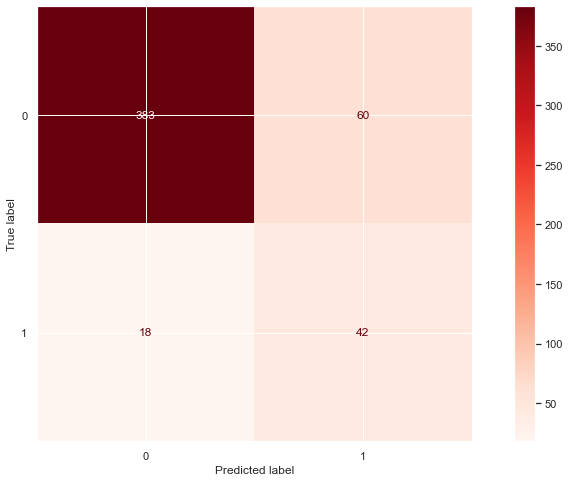

In [47]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

# the function expects the estimator, inputs and target as parameters
plot_confusion_matrix(employee_logit, X_test_ss, y_test, cmap='Reds');

The model predicted:

**383 True Negatives** meaning it correctly predicted **class 0, 382 times**

**42 True Positives** meaning it correctly predicted **class 1, 42 times**

**60 False Positives** meaning it **falsely predicted** class 1, 60 times

**18 False Negatives** meaning it **falsely predicted** class 0, 18 times

Again the raw numbers alone do not tell us a comprehensive story behind the performance of our model and so we will generate a classification report that will provide more information about, **model precision, recall, f1-score and accuracy.**

In [48]:
# Classification report
from sklearn.metrics import classification_report

cf_test_report = classification_report(y_test, y_test_pred)
print(cf_test_report)

              precision    recall  f1-score   support

           0       0.96      0.86      0.91       443
           1       0.41      0.70      0.52        60

    accuracy                           0.84       503
   macro avg       0.68      0.78      0.71       503
weighted avg       0.89      0.84      0.86       503



## Precision, Recall & F1-score are perfomance metrics 

- Precision (also called 'positive predictive value') measures what proportion of a model assigned to positive are actually members of the positive class. It is a measure of how focused our model is. With a high precision we can be confident points our model identifies as belonging to a class do actually belong to a class. 

- Recall (also known as 'sensitivity') measures how many members of the positive class the model correctly identified out of the total positives. With a high recall we can be confident that our model is not missing many class members.

- f1-Score is the harmonic mean of precision and recall. We use the F1 score in order to try and maximize the precision and recall scores simultaneously. Models with a higher F1 score are usually better at predicting the positive class.







## Summarizing the report above, we will focus on 'class 1' which is Attrition:

- The model has a 41% precision rate of predicting attrition. This is a low precision rate, it means our model is not great at correctly predicting attrition.

- The model has a 70% recall rate. This is a relatively high recall rate and it means that our model is great at detecting attrition, however, there will likely be a high rate of false positives

Given our use case, a high recall rate is most preferred because it detects possible attrition, even though the employee may not neccessarily attrition. A high recall rate enables management to be a sensitive as possible and highly engaged with their employees which in turn increases their chances of avoiding attrition before it occurs.

-  The model has an f1-score 52% and accuracy rate of 84% which is relatively good. 

#### In efforts to further enchance our model performance, we will attempt to optimize our model hyperparameters and evaluate the performance results. In this case, we will be optimizing the Logistic Regression C-value.

- C-value is a hyperparameter

- A high value of C tells the model to give more weight to the training data. A lower value of C will indicate the model to give complexity more weight at the cost of fitting the data. Thus, a high C-value indicates that training data is more important and reflects the real world data



### Hyperparameter Optimization

We'll take our train data and split it to create a validation dataset from it. 
* Train: 70%
* Test Set: 30%

Our training data set is the upsampled dataset, that we applied SMOTE on, which is **"X_train_sm2"**

In [49]:
# Splitting the remainder in two chunks
X_train_new, X_validation, y_train_new, y_validation = \
    train_test_split(X_train_sm2, y_train_sm, test_size = 0.3,
                     random_state=1)

In [50]:
print(f'Shape of test set: {X_test.shape}')
print(f'Shape of validation set: {X_validation.shape}')
print(f'Shape of train set: {X_train_new.shape}')

Shape of test set: (503, 10)
Shape of validation set: (621, 10)
Shape of train set: (1447, 10)


- The test set has 503 rows and 10 columns 

- The validation set has 621 rows and 10 columns

- The train set has 1447 rows and 10 columns

In [51]:
# scale the train data and transform it and the validation data
ss_sm2 = StandardScaler().fit(X_train_new)
X_train_new_ss = ss_sm2.transform(X_train_new)
X_validation_ss = ss_sm2.transform(X_validation)


In [52]:
validation_scores = []
train_scores = []

C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,0.1,\
                1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

for c in C_range:
    my_logreg = LogisticRegression(C = c,random_state=1)
    my_logreg.fit(X_train_new_ss,y_train_new)
    
    # train on traning set
    train_scores.append(my_logreg.score(X_train_new_ss,y_train_new))
    # score on validation set
    validation_scores.append(my_logreg.score(X_validation_ss,y_validation))
    

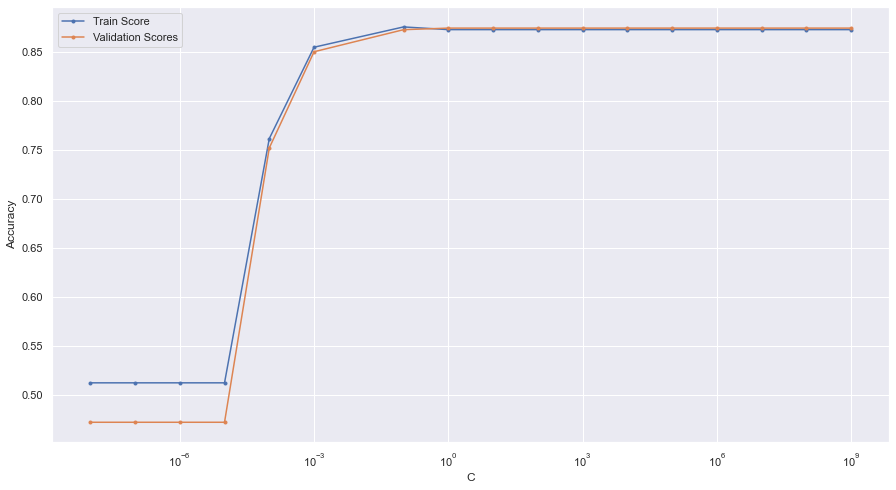

In [53]:
plt.figure()
plt.plot(C_range, train_scores,label="Train Score",marker='.')
plt.plot(C_range, validation_scores,label="Validation Scores",marker='.')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

From the plot above we can observe that the preferred  optimized c-value is [10^(-1)] or 0.1. At this point our model is not overfitting. Both the train score and validation score sit at about **88% accuracy.** These are significantly high accuracy scores, they  good enough for us to accept and trust our model performance.

However, we will now re-model with the preferred c-value and compare the test accuracy scores with the test score of the non-optimized c-value. There after we will re-evaluate the model performance and assess results.

In [54]:
# now we will run our model with the newly identified c-value
my_optimized_employee_model = LogisticRegression(C=0.1,random_state=1)

# Remember that X_train_sm and y_train_sm held the data I split into train_new and validation
# I can use that data to re-train my model
my_optimized_employee_model.fit(X_train_sm_ss,y_train_sm)
print (my_optimized_employee_model.score(X_validation_ss,y_validation))
print (my_optimized_employee_model.score(X_test_ss,y_test))

0.8824476650563607
0.8409542743538767


Validation score is **88% accuracy**  and test score is **84% accuracy** after optimizing our c-value, the test accuracy has not changed from the original, this c-value optimization did not improve our model in any way.The accuracy score actually dropped slightly from **0.8449304174950298 to 0.8409542743538767**

#### We will attempt one more method to optimize hyperparameters, we will employ a pipeline grid search and which will yeaild the best hyperparameter values to use in our model. 

### Now we wil employ a pipeline GridSearch to determine the best estimators and prevailing parameters. 

In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [56]:
# estimators
# note that all the planned steps must be included, but the second elements in each tuple are more like placeholders
estimators = [
    ('scaling', StandardScaler()),
    ('reduce_dim', PCA()),
    ('model', LogisticRegression())
]

# instantiate pipeline with the specified steps
pipe = Pipeline(estimators)

# define parameter grid
param_grid = [
    
    # logistic regression with L1 regularization
    {
        'scaling': [MinMaxScaler(), StandardScaler()],
        'reduce_dim': [PCA()],
        'reduce_dim__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        'model': [LogisticRegression()],
        'model__penalty': ['l1'],
        'model__solver': ['liblinear'],
        'model__C': np.logspace(-5, 5, 11),
        'model__random_state': [1]
    },
    
    # logistic regression with L2 penalty
    {
        'scaling': [MinMaxScaler(), StandardScaler()],
        'reduce_dim': [PCA()],
        'reduce_dim__n_components': [1, 2, 3, 4, 5,6, 7, 8, 9, 10],
        'model': [LogisticRegression()],
        'model__penalty': ['l2'],
        'model__solver': ['lbfgs'],
        'model__C': np.logspace(-5, 5, 11),
        'model__random_state': [1]
    }
]

# instantiate cross-validated grid search object with the steps and parameter grid
grid = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv = 5,
    verbose = 5,
    n_jobs = -1
)

# fit the grid to the training data
grid.fit(X_train_sm2, y_train_sm);

Fitting 5 folds for each of 440 candidates, totalling 2200 fits
[CV 1/5] END model=LogisticRegression(), model__C=1e-05, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=1, scaling=MinMaxScaler();, score=0.500 total time=   0.0s
[CV 3/5] END model=LogisticRegression(), model__C=1e-05, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=2, scaling=MinMaxScaler();, score=0.500 total time=   0.0s
[CV 2/5] END model=LogisticRegression(), model__C=1e-05, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=2, scaling=StandardScaler();, score=0.500 total time=   0.0s
[CV 1/5] END model=LogisticRegression(), model__C=1e-05, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=3, scaling=MinMaxScaler();, score=0.500 total time=   0.0s
[CV 2/5] END model=LogisticReg

[CV 2/5] END model=LogisticRegression(), model__C=0.01, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=5, scaling=MinMaxScaler();, score=0.874 total time=   0.0s
[CV 3/5] END model=LogisticRegression(), model__C=0.01, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=5, scaling=MinMaxScaler();, score=0.841 total time=   0.0s
[CV 4/5] END model=LogisticRegression(), model__C=0.01, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=5, scaling=MinMaxScaler();, score=0.835 total time=   0.0s
[CV 3/5] END model=LogisticRegression(), model__C=0.1, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=4, scaling=MinMaxScaler();, score=0.877 total time=   0.0s
[CV 4/5] END model=LogisticRegression(), model__C=0.1, model__penalty=l1, model__random_state=1, mode

[CV 1/5] END model=LogisticRegression(), model__C=0.01, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=3, scaling=MinMaxScaler();, score=0.725 total time=   0.0s
[CV 2/5] END model=LogisticRegression(), model__C=0.01, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=3, scaling=MinMaxScaler();, score=0.652 total time=   0.0s
[CV 3/5] END model=LogisticRegression(), model__C=0.01, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=3, scaling=MinMaxScaler();, score=0.686 total time=   0.0s
[CV 4/5] END model=LogisticRegression(), model__C=0.01, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=3, scaling=MinMaxScaler();, score=0.656 total time=   0.0s
[CV 5/5] END model=LogisticRegression(), model__C=0.01, model__penalty=l1, model__random_state=1, mo

[CV 1/5] END model=LogisticRegression(), model__C=0.1, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=2, scaling=MinMaxScaler();, score=0.713 total time=   0.0s
[CV 2/5] END model=LogisticRegression(), model__C=0.1, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=2, scaling=MinMaxScaler();, score=0.664 total time=   0.0s
[CV 3/5] END model=LogisticRegression(), model__C=0.1, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=2, scaling=MinMaxScaler();, score=0.686 total time=   0.0s
[CV 4/5] END model=LogisticRegression(), model__C=0.1, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=2, scaling=MinMaxScaler();, score=0.663 total time=   0.0s
[CV 5/5] END model=LogisticRegression(), model__C=0.1, model__penalty=l1, model__random_state=1, model__

[CV 2/5] END model=LogisticRegression(), model__C=0.0001, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=5, scaling=StandardScaler();, score=0.500 total time=   0.0s
[CV 3/5] END model=LogisticRegression(), model__C=0.0001, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=5, scaling=StandardScaler();, score=0.500 total time=   0.0s
[CV 3/5] END model=LogisticRegression(), model__C=0.0001, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=10, scaling=MinMaxScaler();, score=0.500 total time=   0.0s
[CV 4/5] END model=LogisticRegression(), model__C=0.0001, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=10, scaling=MinMaxScaler();, score=0.501 total time=   0.0s
[CV 5/5] END model=LogisticRegression(), model__C=0.0001, model__penalty=l1, model__ra

[CV 5/5] END model=LogisticRegression(), model__C=100.0, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=8, scaling=StandardScaler();, score=0.891 total time=   0.0s
[CV 1/5] END model=LogisticRegression(), model__C=100.0, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=9, scaling=MinMaxScaler();, score=0.816 total time=   0.1s
[CV 2/5] END model=LogisticRegression(), model__C=100.0, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=9, scaling=MinMaxScaler();, score=0.886 total time=   0.0s
[CV 3/5] END model=LogisticRegression(), model__C=100.0, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=9, scaling=MinMaxScaler();, score=0.891 total time=   0.0s
[CV 4/5] END model=LogisticRegression(), model__C=100.0, model__penalty=l1, model__random_stat

[CV 5/5] END model=LogisticRegression(), model__C=0.1, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=8, scaling=MinMaxScaler();, score=0.869 total time=   0.0s
[CV 1/5] END model=LogisticRegression(), model__C=0.1, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=8, scaling=StandardScaler();, score=0.819 total time=   0.0s
[CV 2/5] END model=LogisticRegression(), model__C=0.1, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=8, scaling=StandardScaler();, score=0.884 total time=   0.0s
[CV 3/5] END model=LogisticRegression(), model__C=0.1, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=8, scaling=StandardScaler();, score=0.884 total time=   0.0s
[CV 4/5] END model=LogisticRegression(), model__C=0.1, model__penalty=l1, model__random_state=1, m

[CV 1/5] END model=LogisticRegression(), model__C=10.0, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=8, scaling=MinMaxScaler();, score=0.809 total time=   0.0s
[CV 2/5] END model=LogisticRegression(), model__C=10.0, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=8, scaling=MinMaxScaler();, score=0.891 total time=   0.0s
[CV 5/5] END model=LogisticRegression(), model__C=100.0, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=5, scaling=MinMaxScaler();, score=0.850 total time=   0.0s
[CV 1/5] END model=LogisticRegression(), model__C=100.0, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=5, scaling=StandardScaler();, score=0.804 total time=   0.0s
[CV 2/5] END model=LogisticRegression(), model__C=100.0, model__penalty=l1, model__random_state=

[CV 2/5] END model=LogisticRegression(), model__C=0.01, model__penalty=l2, model__random_state=1, model__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=4, scaling=MinMaxScaler();, score=0.870 total time=   0.0s
[CV 5/5] END model=LogisticRegression(), model__C=0.01, model__penalty=l2, model__random_state=1, model__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=7, scaling=MinMaxScaler();, score=0.874 total time=   0.0s
[CV 1/5] END model=LogisticRegression(), model__C=0.01, model__penalty=l2, model__random_state=1, model__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=7, scaling=StandardScaler();, score=0.816 total time=   0.0s
[CV 2/5] END model=LogisticRegression(), model__C=0.01, model__penalty=l2, model__random_state=1, model__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=7, scaling=StandardScaler();, score=0.889 total time=   0.0s
[CV 3/5] END model=LogisticRegression(), model__C=0.01, model__penalty=l2, model__random_state=1, model__solver=

[CV 3/5] END model=LogisticRegression(), model__C=10.0, model__penalty=l2, model__random_state=1, model__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=10, scaling=MinMaxScaler();, score=0.889 total time=   0.0s
V 3/5] END model=LogisticRegression(), model__C=0.001, model__penalty=l2, model__random_state=1, model__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=9, scaling=MinMaxScaler();, score=0.877 total time=   0.0s
[CV 4/5] END model=LogisticRegression(), model__C=0.001, model__penalty=l2, model__random_state=1, model__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=9, scaling=MinMaxScaler();, score=0.877 total time=   0.0s
[CV 2/5] END model=LogisticRegression(), model__C=0.01, model__penalty=l2, model__random_state=1, model__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=2, scaling=StandardScaler();, score=0.841 total time=   0.0s
[CV 3/5] END model=LogisticRegression(), model__C=0.01, model__penalty=l2, model__random_state=1, model__solver=l

After fitting the grid to the training data, use the `best_estimator_` attribute on your grid search object to obtain the most optimal model and its parameters. 

In [57]:
# check the most optimal model
grid.best_estimator_

Pipeline(steps=[('scaling', StandardScaler()),
                ('reduce_dim', PCA(n_components=8)),
                ('model',
                 LogisticRegression(C=1000.0, penalty='l1', random_state=1,
                                    solver='liblinear'))])

The best estimator recommended to us requires us to the MinMaxScaler, perform dimension reduction 10 components, using logistric regression with a c-value of 0.1 and a random state of 1.

We will now implement these recommendations and evaluate our model.

### Now using our best estimator we will re-run our model with the specified parameters and evaluate the model

In [58]:
# The best estimator suggests we use the standard scaler 

# make a scaler & fit
ss_scaler = StandardScaler().fit(X_train_sm2)


# transform the data
X_train_sm_sc = ss_scaler.transform(X_train_sm2)
X_test_sc = ss_scaler.transform(X_test)


In [59]:
# The best estimator suggest we reduce dimensionality using PCA to 8 components

# Instantiate and fit
my_PCA = PCA(n_components = 8)
my_PCA.fit(X_train_sm_sc)

# Transform train and test
X_train_PCA = my_PCA.transform(X_train_sm_sc)
X_test_PCA = my_PCA.transform(X_test_sc)

In [60]:
# Now fit the logistic regression with the best estimator suggested hyper-parameters

# Instantiate the model 
my_final_employee_model = LogisticRegression(C=1000.0,random_state=1,penalty='l1', solver='liblinear' )

# Fit the model 
my_final_employee_model.fit(X_train_PCA,y_train_sm)

# Score the model 
print (my_final_employee_model.score(X_train_PCA,y_train_sm))

print (my_final_employee_model.score(X_test_PCA,y_test))

0.8829787234042553
0.8409542743538767


After optimizing the hyper-parameters the accuracy did not change significantly, the train accuracy remained at 88% and the test accuracy remained at 84%. This does not neccessarily mean that optimizing hyper paramenters does not woro or help improve our model. Our data is not significantly large itself and so making these adjustments on a small data set may not have a significant impact.

We will go one and evaluate the other performance metric of the model other than the accuracy alone and check for any improvements

### Evaluation on Test Data - After fitting the best estimators and fitting the parameters in the Logistic Regression Model 

In [61]:
# class distribution
display(y_test.value_counts())

0    443
1     60
Name: Attrition, dtype: int64

In [62]:
# predict classification
y_test_pred = my_final_employee_model.predict(X_test_PCA)

Generate the (raw) confusion matrix:

In [63]:
cf_test = confusion_matrix(y_test, y_test_pred)
cf_test

array([[379,  64],
       [ 16,  44]])

In [64]:
# confusion matrix
conmat = pd.DataFrame(
    data = cf_test,
    index = ['true 0', 'true 1'],
    columns = ['predicted 0', 'predicted 1']
)
display(conmat)

,predicted 0,predicted 1
true 0,379,64
true 1,16,44


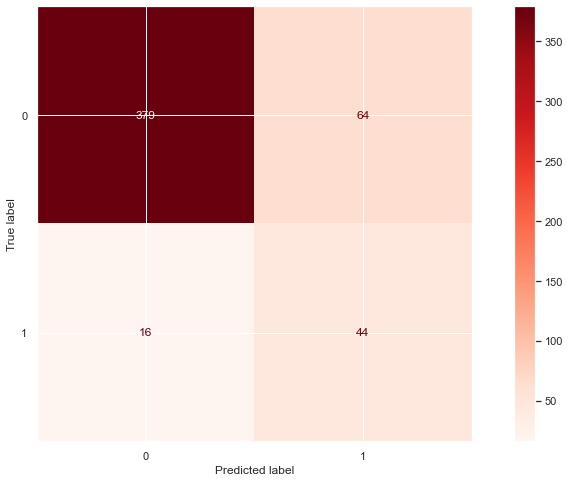

In [65]:
# the function expects the estimator, inputs and target as parameters
plot_confusion_matrix(my_final_employee_model, X_test_PCA, y_test, cmap='Reds');

The model predicted:

**379 True Negatives** meaning it correctly predicted **class 0, 379 times**

**44 True Positives** meaning it correctly predicted **class 1, 44 times**

**64 False Positives** meaning it **falsely predicted** class 1, 64 times

**16 False Negatives** meaning it **falsely predicted** class 0, 16 times


Compared to the original:

**383 True Negatives** meaning it correctly predicted **class 0, 382 times**

**42 True Positives** meaning it correctly predicted **class 1, 42 times**

**60 False Positives** meaning it **falsely predicted** class 1, 60 times

**18 False Negatives** meaning it **falsely predicted** class 0, 18 times



Although not significant, optimizing our hyperparameters resulted in slight changes in the predictions. Given that the number of True positives and False positives increase, I would assume that the recall rate increase. We will verify this assumption from the classification report.

In [66]:
# Optimized model Classification report

cf_test_report = classification_report(y_test, y_test_pred)
print(cf_test_report)

              precision    recall  f1-score   support

           0       0.96      0.86      0.90       443
           1       0.41      0.73      0.52        60

    accuracy                           0.84       503
   macro avg       0.68      0.79      0.71       503
weighted avg       0.89      0.84      0.86       503

[CV 5/5] END model=LogisticRegression(), model__C=1000.0, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=10, scaling=MinMaxScaler();, score=0.891 total time=   0.0s
[CV 1/5] END model=LogisticRegression(), model__C=1000.0, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=10, scaling=StandardScaler();, score=0.812 total time=   0.1s
[CV 2/5] END model=LogisticRegression(), model__C=100000.0, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=6, scaling=StandardScaler();, score=0.896 tot

[CV 5/5] END model=LogisticRegression(), model__C=10000.0, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=6, scaling=MinMaxScaler();, score=0.867 total time=   0.0s
[CV 1/5] END model=LogisticRegression(), model__C=10000.0, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=6, scaling=StandardScaler();, score=0.804 total time=   0.0s
[CV 2/5] END model=LogisticRegression(), model__C=10000.0, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=6, scaling=StandardScaler();, score=0.896 total time=   0.0s
[CV 3/5] END model=LogisticRegression(), model__C=10000.0, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=6, scaling=StandardScaler();, score=0.877 total time=   0.0s
[CV 4/5] END model=LogisticRegression(), model__C=10000.0, model__penalty=l1, mode

[CV 2/5] END model=LogisticRegression(), model__C=10000.0, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=4, scaling=StandardScaler();, score=0.886 total time=   0.0s
[CV 3/5] END model=LogisticRegression(), model__C=10000.0, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=4, scaling=StandardScaler();, score=0.836 total time=   0.0s
[CV 4/5] END model=LogisticRegression(), model__C=10000.0, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=4, scaling=StandardScaler();, score=0.877 total time=   0.0s
[CV 5/5] END model=LogisticRegression(), model__C=10000.0, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=4, scaling=StandardScaler();, score=0.864 total time=   0.0s
[CV 1/5] END model=LogisticRegression(), model__C=10000.0, model__penalty=l1, mo

[CV 1/5] END model=LogisticRegression(), model__C=10000.0, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=1, scaling=MinMaxScaler();, score=0.727 total time=   0.0s
[CV 2/5] END model=LogisticRegression(), model__C=10000.0, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=1, scaling=MinMaxScaler();, score=0.647 total time=   0.0s
[CV 3/5] END model=LogisticRegression(), model__C=10000.0, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=1, scaling=MinMaxScaler();, score=0.691 total time=   0.0s
[CV 4/5] END model=LogisticRegression(), model__C=10000.0, model__penalty=l1, model__random_state=1, model__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=1, scaling=MinMaxScaler();, score=0.659 total time=   0.0s
[CV 4/5] END model=LogisticRegression(), model__C=10000.0, model__penalty=l1, model__ran

[CV 3/5] END model=LogisticRegression(), model__C=0.1, model__penalty=l2, model__random_state=1, model__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=1, scaling=StandardScaler();, score=0.785 total time=   0.0s
[CV 4/5] END model=LogisticRegression(), model__C=0.1, model__penalty=l2, model__random_state=1, model__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=1, scaling=StandardScaler();, score=0.787 total time=   0.0s
[CV 5/5] END model=LogisticRegression(), model__C=0.1, model__penalty=l2, model__random_state=1, model__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=1, scaling=StandardScaler();, score=0.797 total time=   0.0s
[CV 1/5] END model=LogisticRegression(), model__C=0.1, model__penalty=l2, model__random_state=1, model__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=2, scaling=MinMaxScaler();, score=0.684 total time=   0.0s
[CV 2/5] END model=LogisticRegression(), model__C=0.1, model__penalty=l2, model__random_state=1, model__solver=lbf

[CV 4/5] END model=LogisticRegression(), model__C=0.01, model__penalty=l2, model__random_state=1, model__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=7, scaling=MinMaxScaler();, score=0.867 total time=   0.0s
[CV 2/5] END model=LogisticRegression(), model__C=0.01, model__penalty=l2, model__random_state=1, model__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=10, scaling=StandardScaler();, score=0.884 total time=   0.0s
[CV 3/5] END model=LogisticRegression(), model__C=0.01, model__penalty=l2, model__random_state=1, model__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=10, scaling=StandardScaler();, score=0.889 total time=   0.0s
[CV 4/5] END model=LogisticRegression(), model__C=0.01, model__penalty=l2, model__random_state=1, model__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=10, scaling=StandardScaler();, score=0.886 total time=   0.0s
[CV 5/5] END model=LogisticRegression(), model__C=0.01, model__penalty=l2, model__random_state=1, model__so

[CV 4/5] END model=LogisticRegression(), model__C=100.0, model__penalty=l2, model__random_state=1, model__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=5, scaling=StandardScaler();, score=0.877 total time=   0.0s
[CV 5/5] END model=LogisticRegression(), model__C=100.0, model__penalty=l2, model__random_state=1, model__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=5, scaling=StandardScaler();, score=0.850 total time=   0.0s
[CV 1/5] END model=LogisticRegression(), model__C=100.0, model__penalty=l2, model__random_state=1, model__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=6, scaling=MinMaxScaler();, score=0.821 total time=   0.0s
[CV 2/5] END model=LogisticRegression(), model__C=100.0, model__penalty=l2, model__random_state=1, model__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=6, scaling=MinMaxScaler();, score=0.884 total time=   0.0s
[CV 3/5] END model=LogisticRegression(), model__C=100.0, model__penalty=l2, model__random_state=1, model__so

After optimizing the hyperparameters using a pipeline GridSearch, the class 1 precision rate remained the same at 41%, the recall rate increased from 70% to 73%. The f1-score remained the same at 52% and the test accuracy also remained the same at 84%.

As I assumed, the recall rate slightly increased. Again, given our use case, where it is preferred to detect as many attrition possibilities, optimizing the hyperparameters actually worked in our favor and improved our model performance





## This is the end of our Logistic Regression Model.

The next step will be deploying the model into production and create a tool that management will be able to use to retain attrition probabilities of their employees.